# Visualization of Utah COVID-19 Cases for 2020

Inspiration for these visualizations came from [Matt Harrison's](https://www.linkedin.com/in/panela/) daily COVID-19 plots that he began publishing on LinkedIn during the spring of 2020.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
sns.set(context='talk', palette='deep', color_codes=True, style='darkgrid')

Let me see all columns

In [4]:
pd.options.display.max_columns = 999

This is required to eliminate a pandas deprecation warning related to implicit datetime conversions.

In [5]:
pd.plotting.register_matplotlib_converters()

## Data Loading
[The COVID Tracking Project](https://covidtracking.com/api) is the data provider.

In [6]:
# Local disk
# url = r"C:\src\covid-tracking-data\data\states_daily_4pm_et.csv"

# COVID Tracking Project API for daily data
url = 'https://covidtracking.com/api/v1/states/ut/daily.csv'

In [7]:
df = pd.read_csv(url, parse_dates=['date', 'dateChecked'])

## Data Cleaning

There are deprecated columns in the daily data table that are no longer being maintained. We'll keep only active and relevant columns.

In [8]:
cols_to_keep = [
    'date',
    'positive',
    'negative',
    'hospitalizedCumulative',
    'death',
]

In [9]:
df = df[cols_to_keep].set_index('date').sort_index().copy()

Backfill missing values for negative test results.

In [10]:
df['negative'] = df['negative'].fillna(0)

Add column for total number of tests.

In [11]:
df['totalTests'] = df['positive'] + df['negative']

Store running seven-day average of daily case increments.

In [12]:
df_daily = df.diff()
df_daily = df_daily.rolling(pd.Timedelta(7, 'days')).mean()

## Handy Plot Formatting Tools

In [13]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
formatter = mdates.ConciseDateFormatter(days)

## Matt Harrison's Original Plot

With some added `seaborn` styling....

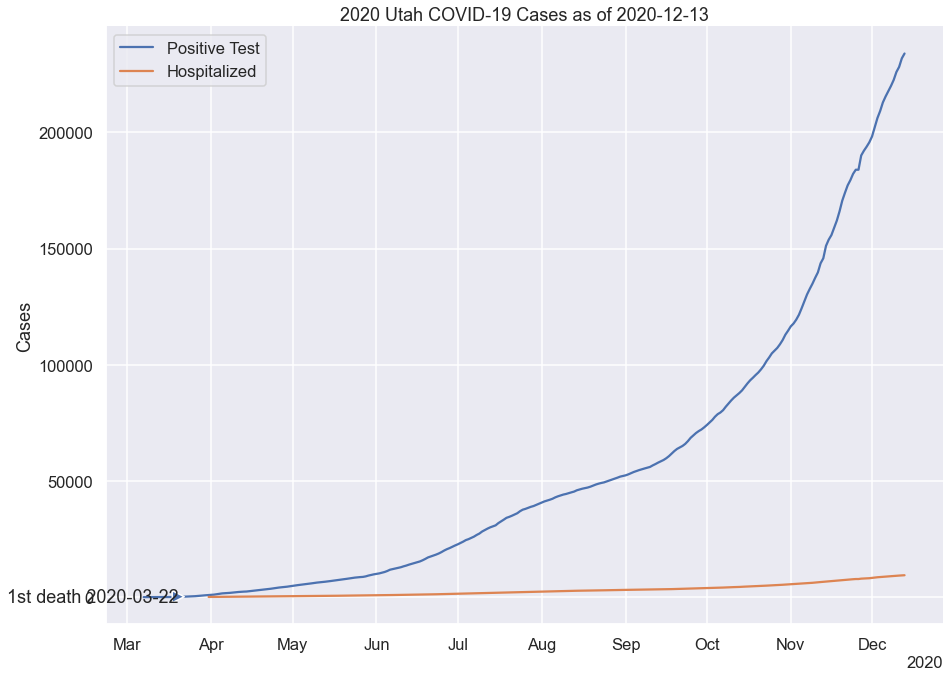

In [14]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(15, 11))
    ax.plot(df.positive, label='Positive Test')
    ax.plot(df.hospitalizedCumulative, label='Hospitalized')
    ax.set_ylabel('Cases')
    ax.set_title(f'2020 Utah COVID-19 Cases as of {df.index[-1]:%Y-%m-%d}')

#     ax.xaxis.set_major_locator(days)
    ax.xaxis.set_major_formatter(formatter)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    deaths = [
        ('1st', pd.Timestamp('2020-03-22')),
#         ('2nd', pd.Timestamp('2020-03-27')),
#         ('3rd/4th', pd.Timestamp('2020-03-29')),
#         ('5th', pd.Timestamp('2020-03-31')),
#         ('6th/7th', pd.Timestamp('2020-04-01'))
    ]
    
    for num, date in deaths:
        val = df.loc[date, 'positive']
        ax.annotate(f'{num} death {date.strftime("%Y-%m-%d")}',
                    xy=(date, val),
                    xytext=(date - pd.DateOffset(days=2), val),
                    arrowprops={},
                    horizontalalignment='right',
                    verticalalignment='center'
                   )
    sns.despine()
    ax.legend(loc='upper left')

## Break Out Subplots

How does it look if we break everything out into subplots instead?

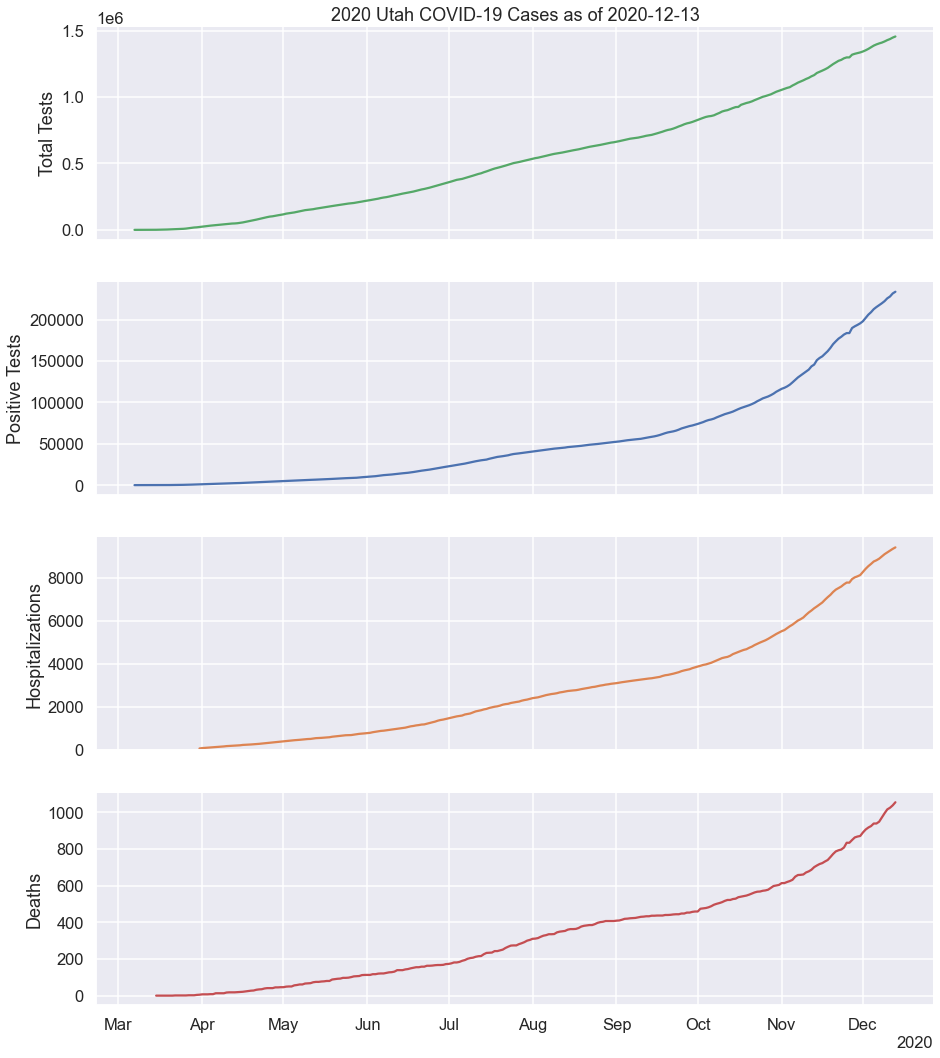

In [15]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(4, 1, figsize=(15, 18), sharex=True)
 
    ax[0].plot(df.totalTests, color='C2', label='Total Tests')
    ax[0].set_ylabel('Total Tests')
    ax[0].set_title(f'2020 Utah COVID-19 Cases as of {df.index[-1]:%Y-%m-%d}')
    
    ax[1].plot(df.positive, color='C0', label='Positive Test')
    ax[1].set_ylabel('Positive Tests')
    
    ax[2].plot(df.hospitalizedCumulative, color='C1', label='Hospitalized')
    ax[2].set_ylabel('Hospitalizations')
    ax[2].set_ylim(bottom=0)
    
    ax[3].plot(df.death, color='C3', label='Deaths')
    ax[3].set_ylabel('Deaths')

#     ax[0].xaxis.set_major_locator(days)
    ax[0].xaxis.set_major_formatter(formatter)
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=0)
    
    sns.despine()

## Multiple Y Axes on Single Plot

The subplots indicate similar curve shapes. Let's express them on a common plot with multiple y axes.

Inspiration for the multiple axes technique comes from the [Multiple Yaxis Wtih Spines](https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html) example on the matplotlib site.

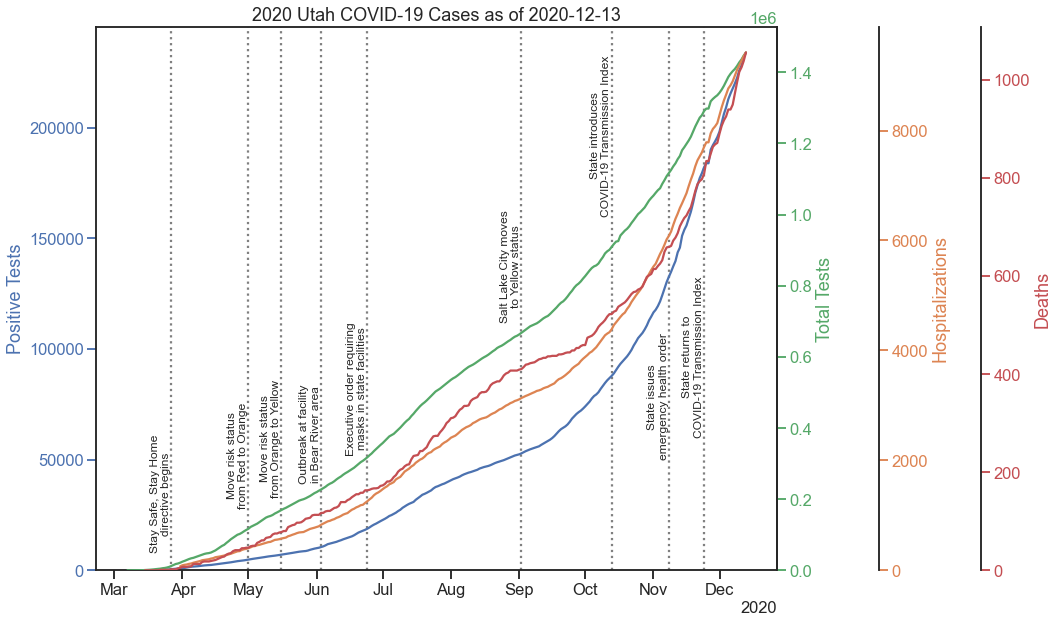

In [16]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.plot(df.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases as of {df.index[-1]:%Y-%m-%d}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=0.0)
    ax_0.tick_params(axis='y', colors=line_0.get_color(), **tick_kws)
    
    # Add public health directive markers
    ax_0.axvline('2020-03-27', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Stay Safe, Stay Home\ndirective begins",
                    xy=('2020-03-22', 8000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    ax_0.axvline('2020-05-01', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Red to Orange",
                    xy=('2020-04-26', 28000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    ax_0.axvline('2020-05-16', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Orange to Yellow",
                    xy=('2020-05-11', 33000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-06-03', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Outbreak at facility\nin Bear River area",
                    xy=('2020-05-29', 39000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-06-24', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Executive order requiring\nmasks in state facilities",
                    xy=('2020-06-19', 52000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-09-02', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Salt Lake City moves\nto Yellow status",
                    xy=('2020-08-28', 112000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-10-13', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State introduces\nCOVID-19 Transmission Index",
                    xy=('2020-10-08', 160000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-11-08', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State issues\nemergency health order",
                    xy=('2020-11-03', 50000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-11-24', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State returns to\nCOVID-19 Transmission Index",
                    xy=('2020-11-19', 60000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    line_1, = ax_1.plot(df.totalTests, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=0.0)
    ax_1.tick_params(axis='y', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.plot(df.hospitalizedCumulative, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=0.0)
    ax_2.tick_params(axis='y', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.plot(df.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=0.0)
    ax_3.tick_params(axis='y', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()

## Multiple Y Axes on Single Plot, Log Scaling on Y

Shameless copy-paste of the plot above to experiment with log y scaling.

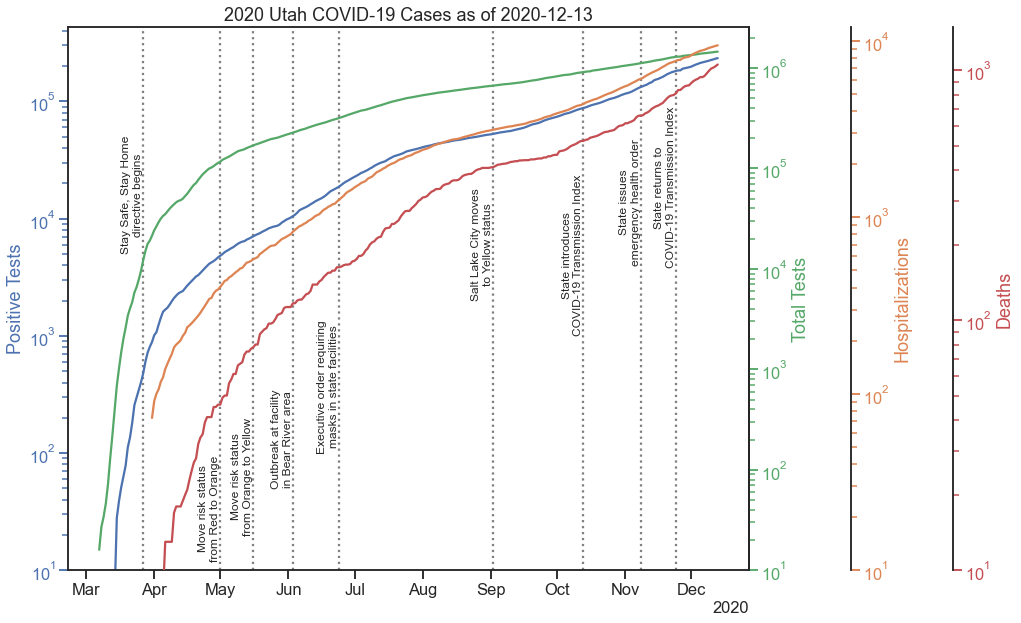

In [17]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.semilogy(df.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Cases as of {df.index[-1]:%Y-%m-%d}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=10.0)
    ax_0.tick_params(axis='y', which='both', colors=line_0.get_color(), **tick_kws)
    
    # Add public health directive markers
    ax_0.axvline('2020-03-27', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Stay Safe, Stay Home\ndirective begins",
                    xy=('2020-03-22', 5000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    ax_0.axvline('2020-05-01', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Red to Orange",
                    xy=('2020-04-26', 12),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    ax_0.axvline('2020-05-16', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Orange to Yellow",
                    xy=('2020-05-11', 20),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )

    ax_0.axvline('2020-06-03', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Outbreak at facility\nin Bear River area",
                    xy=('2020-05-29', 50),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-06-24', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Executive order requiring\nmasks in state facilities",
                    xy=('2020-06-19', 100),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-09-02', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Salt Lake City moves\nto Yellow status",
                    xy=('2020-08-28', 2000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-10-13', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State introduces\nCOVID-19 Transmission Index",
                    xy=('2020-10-08', 1000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-11-08', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State issues\nemergency health order",
                    xy=('2020-11-03', 4000),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-11-24', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State returns to\nCOVID-19 Transmission Index",
                    xy=('2020-11-19', 3800),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    line_1, = ax_1.semilogy(df.totalTests, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=10.0)
    ax_1.tick_params(axis='y', which='both', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.semilogy(df.hospitalizedCumulative, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=10.0)
    ax_2.tick_params(axis='y', which='both', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.semilogy(df.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=10.0)
    ax_3.tick_params(axis='y', which='both', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_multiple_log_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()

## Daily Case Increments

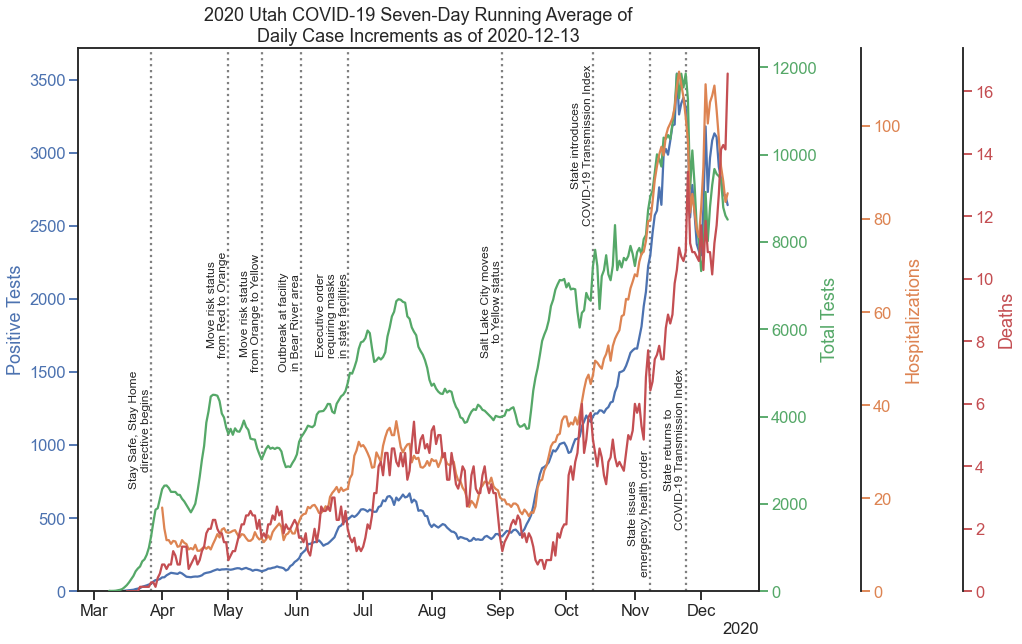

In [21]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

with sns.axes_style('ticks'):
    fig, ax_0 = plt.subplots(1, 1, figsize=(18, 10), sharex=True)
    fig.subplots_adjust(right=0.65)

    ax_1 = ax_0.twinx()
    ax_2 = ax_0.twinx()
    ax_3 = ax_0.twinx()

    ax_2.spines['right'].set_position(('axes', 1.15))
    ax_3.spines['right'].set_position(('axes', 1.3))

    make_patch_spines_invisible(ax_1)
    make_patch_spines_invisible(ax_2)
    make_patch_spines_invisible(ax_3)

    ax_1.spines['right'].set_visible(True)
    ax_2.spines['right'].set_visible(True)
    ax_3.spines['right'].set_visible(True)

    tick_kws = dict()

    line_0, = ax_0.plot(df_daily.positive, color='C0', label='Positive Test')
    ax_0.set_ylabel('Positive Tests')
    ax_0.set_title(f'2020 Utah COVID-19 Seven-Day Running Average of\nDaily Case Increments as of {df_daily.index[-1]:%Y-%m-%d}')
    ax_0.yaxis.label.set_color(line_0.get_color())
    ax_0.set_ylim(bottom=0.0)
    ax_0.tick_params(axis='y', colors=line_0.get_color(), **tick_kws)
    
    # Add public health directive markers
    ax_0.axvline('2020-03-27', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Stay Safe, Stay Home\ndirective begins",
                    xy=('2020-03-22', 700),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-05-01', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Red to Orange",
                    xy=('2020-04-26', 1600),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-05-16', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Move risk status\nfrom Orange to Yellow",
                    xy=('2020-05-11', 1500),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-06-03', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Outbreak at facility\nin Bear River area",
                    xy=('2020-05-29', 1500),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-06-24', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Executive order\nrequiring masks\nin state facilities",
                    xy=('2020-06-17', 1600),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-09-02', color='gray', ls=':', zorder=-1)
    ax_0.annotate("Salt Lake City moves\nto Yellow status",
                    xy=('2020-08-28', 1600),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-10-13', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State introduces\nCOVID-19 Transmission Index",
                    xy=('2020-10-08', 2500),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-11-08', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State issues\nemergency health order",
                    xy=('2020-11-03', 100),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    ax_0.axvline('2020-11-24', color='gray', ls=':', zorder=-1)
    ax_0.annotate("State returns to\nCOVID-19 Transmission Index",
                    xy=('2020-11-19', 420),
                    size=12,
                    rotation=90,
                    horizontalalignment='center',
                    verticalalignment='bottom'
                   )
    
    line_1, = ax_1.plot(df_daily.totalTests, color='C2', label='Total Tests')
    ax_1.set_ylabel('Total Tests')
    ax_1.yaxis.label.set_color(line_1.get_color())
    ax_1.set_ylim(bottom=0.0)
    ax_1.tick_params(axis='y', colors=line_1.get_color(), **tick_kws)

    line_2, = ax_2.plot(df_daily.hospitalizedCumulative, color='C1', label='Hospitalized')
    ax_2.set_ylabel('Hospitalizations')
    ax_2.yaxis.label.set_color(line_2.get_color())
    ax_2.set_ylim(bottom=0.0)
    ax_2.tick_params(axis='y', colors=line_2.get_color(), **tick_kws)

    line_3, = ax_3.plot(df_daily.death, color='C3', label='Deaths')
    ax_3.set_ylabel('Deaths')
    ax_3.yaxis.label.set_color(line_3.get_color())
    ax_3.set_ylim(bottom=0.0)
    ax_3.tick_params(axis='y', colors=line_3.get_color(), **tick_kws)

#     ax_0.xaxis.set_major_locator(days)
    ax_0.xaxis.set_major_formatter(formatter)
    plt.setp(ax_0.xaxis.get_majorticklabels(), rotation=0)

fig.savefig('covid_daily_increments_multiple_y_axes.png', dpi=300, bbox_inches='tight')
#     sns.despine()

In [19]:
df.tail(8)

,positive,negative,hospitalizedCumulative,death,totalTests
date,,,,,
2020-12-06,215407,1180321,8822.0,939.0,1395728
2020-12-07,217638,1185465,8896.0,949.0,1403103
2020-12-08,219971,1189392,9003.0,972.0,1409363
2020-12-09,222545,1195348,9105.0,995.0,1417893
2020-12-10,225946,1202027,9187.0,1016.0,1427973
2020-12-11,228129,1207924,9269.0,1025.0,1436053
2020-12-12,231821,1215129,9351.0,1038.0,1446950
2020-12-13,233904,1221415,9421.0,1055.0,1455319
